<a href="https://colab.research.google.com/github/ctorney/speciesInteract/blob/master/gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x


import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import math
from math import *
from scipy.stats import binned_statistic_2d

import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
!curl -L -o files.zip https://www.dropbox.com/sh/1nnszef6rqoihhp/AAA-1D9M8MWnPfpajd0B3sFCa?dl=1
!mkdir data
!unzip files.zip -d data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  480M  100  480M    0     0  16.3M      0  0:00:29  0:00:29 --:--:-- 6626k
mkdir: cannot create directory ‘data’: File exists
Archive:  files.zip
mapname:  conversion of  failed
replace data/out.mp4? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: data/out.mp4            
replace data/out2.mp4? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: data/out2.mp4           
 extracting: data/orderw.png         
 extracting: data/orderz.png         
 extracting: data/clipList.csv       
 extracting: data/toOriginw.png      
 extracting: data/toOriginz.png      
 extracting: data/densityHMz.png     
 extracting: data/densityHMw.png     
 extracting: data/clipListReduced.c

In [0]:



DATADIR = 'data/'

OUTDIR ='data/'
CLIPLIST = DATADIR + 'clipListReduced.csv'

df = pd.read_csv(CLIPLIST)
allDF = pd.DataFrame()

worz = 'w'
for index, row in df.iterrows():
    #if index!=4:
    #    continue
    noext, ext = os.path.splitext(row.clipname)   
    posfilename = OUTDIR +  '/TRACKS_' + noext + '.csv'
    posDF = pd.read_csv(posfilename) 
    posDF['clip']=index
    posDF = posDF[posDF['animal']==worz]
    posDF = posDF[posDF['frame']%10==0]

    allDF = allDF.append(posDF,ignore_index=True)
    
        
    

        
# convert to a numpy array
allData = allDF.values


rowCount = len(allData)


# build an array to store the relative angles and distances to all neighbours
locations = np.zeros((0,4)).astype(np.float32) 
for thisRow in range(rowCount):
    thisTime = allData[thisRow,0]        
    thisX = allData[thisRow,1]
    thisY = allData[thisRow,2]
    thisAngle = (allData[thisRow,5])
    thisVx = allData[thisRow,6]
    thisVy = allData[thisRow,7]
    thisAx = allData[thisRow,8]
    thisAy = allData[thisRow,9]
    #thisAngle = atan2(allData[thisRow,7],allData[thisRow,6])
    thisTrack = (allData[thisRow,10])
    thisClip = allData[thisRow,12]
    # find all animals at this time point in the clip that aren't the focal individual
    window = allData[(allData[:,0]==thisTime)&(allData[:,12]==thisClip)&(allData[:,10]!=thisTrack),:]
    rowLoc = np.zeros((0,4)).astype(np.float32) 
    for w in window:
        xj = w[1]
        yj = w[2]
        vxj = w[6]
        vyj = w[7]
        dx = xj - thisX
        dy = yj - thisY
        relVelx = vxj - thisVx
        relVely = vyj - thisVy

        relvel = relVelx*dx + relVely*dy
        relacc = thisAx*dx + thisAy*dy
        jAngle = (w[5])
        r = ((((thisX-xj)**2+(thisY-yj)**2))**0.5) 
        if r>20:
            continue

        angle = math.atan2(dy,dx)
        angle = angle - thisAngle
        jAngle = jAngle - thisAngle
        #angle = math.atan2(dy,dx)
        theta = math.atan2(math.sin(angle), math.cos(angle))
        jHeading  = math.atan2(math.sin(jAngle), math.cos(jAngle))
        rowLoc = np.vstack((rowLoc,[r, theta, relvel,relacc]))
    locations = np.vstack((locations,rowLoc))


In [0]:

## POLAR PLOT OF ATTRACTION


# find the average cos and sin of the relative headings to calculate circular statistics
histcos=binned_statistic_2d(x=locations[:,0],y=locations[:,1],values=cosRelativeAngles, statistic='mean', bins=[r2,theta2])[0]  
histsin=binned_statistic_2d(x=locations[:,0],y=locations[:,1],values=sinRelativeAngles, statistic='mean', bins=[r2,theta2])[0]  


angles = 0.5*(theta2[0:-1]+theta2[1:])
angles=np.tile(angles,(binn2,1))

toOrigin = -(histcos*np.cos(angles) + histsin*np.sin(angles))
fig1=plt.figure(figsize=(8,8))
ax2=plt.subplot(projection="polar",frameon=False)
im=ax2.pcolormesh(theta2,r2,toOrigin,lw=0.0,vmin=np.nanmin(toOrigin),vmax=np.nanmax(toOrigin),cmap='viridis')
ax2.yaxis.set_visible(False)

# angle lines
ax2.set_thetagrids(angles=np.arange(0,360,45),labels=['', '45°', '90°', '135°', '', '225°','270°', '315°'])
ax1 = ax2.figure.add_axes(ax2.get_position(), projection='polar',label='twin', frame_on=False,theta_direction=ax2.get_theta_direction(), theta_offset=ax2.get_theta_offset())
ax1.yaxis.set_visible(False)
ax1.set_thetagrids(angles=np.arange(0,360,45),labels=['front', '', '',  '', 'back', '','', ''],frac=1.1)
#colourbar
position=fig1.add_axes([1.1,0.12,0.04,0.8])
cbar=plt.colorbar(im,cax=position) 
cbar.set_label('Relative direction', rotation=90,fontsize='xx-large',labelpad=15)      

#body length legend - draws the ticks and 
axes=ax2            
factor = 0.98
d = axes.get_yticks()[-1] #* factor
r_tick_labels = [0] + axes.get_yticks()
r_ticks = (np.array(r_tick_labels) ** 2 + d ** 2) ** 0.5
theta_ticks = np.arcsin(d / r_ticks) + np.pi / 2
r_axlabel = (np.mean(r_tick_labels) ** 2 + d ** 2) ** 0.5
theta_axlabel = np.arcsin(d / r_axlabel) + np.pi / 2

# fixed offsets in x
offset_spine = transforms.ScaledTranslation(-100, 0, axes.transScale)
offset_ticklabels = transforms.ScaledTranslation(-10, 0, axes.transScale)
offset_axlabel = transforms.ScaledTranslation(-40, 0, axes.transScale)

# apply these to the data coordinates of the line/ticks
trans_spine = axes.transData + offset_spine
trans_ticklabels = trans_spine + offset_ticklabels
trans_axlabel = trans_spine + offset_axlabel
axes.plot(theta_ticks, r_ticks, '-_k', transform=trans_spine, clip_on=False)

# plot the 'tick labels'
for ii in range(len(r_ticks)):
    axes.text(theta_ticks[ii], r_ticks[ii], "%.0f" % r_tick_labels[ii], ha="right", va="center", clip_on=False, transform=trans_ticklabels)

# plot the 'axis label'
axes.text(theta_axlabel, r_axlabel, 'metres',rotation='vertical', fontsize='xx-large', ha='right', va='center', clip_on=False, transform=trans_axlabel)#             family='Trebuchet MS')




AttributeError: ignored

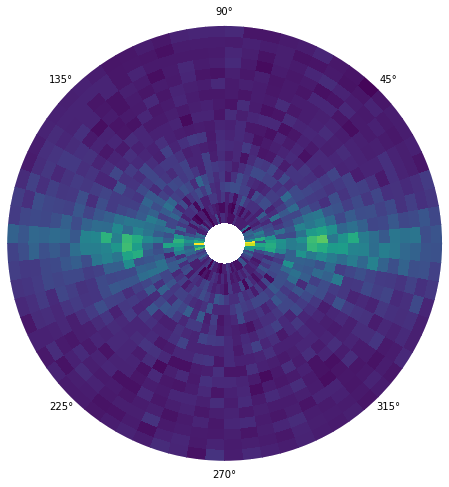

In [0]:


## POLAR PLOT OF RELATIVE POSITIONS
#BL = is approx 32 pixels
binn2=19 # distance bins
binn1=72

dr = 0.25 # width of distance bins
sr = 0.5 # start point of distance
maxr=sr+(dr*binn2)
theta2 = np.linspace(0.0,2.0 * np.pi, binn1+1)
r2 = np.linspace(sr, maxr, binn2+1)
areas = pi*((r2+dr)**2-r2**2)
areas = areas[0:-1]
areas=np.tile(areas,(binn1,1)).T

# wrap to [0, 2pi]
locations[locations[:,1]<0,1] = locations[locations[:,1]<0,1] + 2 *pi

hista2=np.histogram2d(x=locations[:,0],y=locations[:,1],bins=[r2,theta2],normed=1)[0]  

hista2 =hista2/areas

size = 8
# make a square figure

fig1=plt.figure(figsize=(8,8))
ax2=plt.subplot(projection="polar",frameon=False)
im=ax2.pcolormesh(theta2,r2,hista2,lw=0.0,vmin=np.min(hista2),vmax=np.max(hista2),cmap='viridis')
#im=ax2.pcolormesh(theta2,r2,hista2,lw=0.0,vmin=0.0005,vmax=0.002,cmap='viridis')
ax2.yaxis.set_visible(False)

# angle lines
ax2.set_thetagrids(angles=np.arange(0,360,45),labels=['', '45°', '90°', '135°', '', '225°','270°', '315°'],frac=1.1)
ax1 = ax2.figure.add_axes(ax2.get_position(), projection='polar',label='twin', frame_on=False,theta_direction=ax2.get_theta_direction(), theta_offset=ax2.get_theta_offset())
ax1.yaxis.set_visible(False)
ax1.set_thetagrids(angles=np.arange(0,360,45),labels=['front', '', '',  '', 'back', '','', ''],frac=1.1)
#colourbar
position=fig1.add_axes([1.1,0.12,0.04,0.8])
cbar=plt.colorbar(im,cax=position) 
cbar.set_label('Neighbour density', rotation=90,fontsize='xx-large',labelpad=15)      

#body length legend - draws the ticks and 
axes=ax2            
factor = 0.98
d = axes.get_yticks()[-1] #* factor
r_tick_labels = [0] + axes.get_yticks()
r_ticks = (np.array(r_tick_labels) ** 2 + d ** 2) ** 0.5
theta_ticks = np.arcsin(d / r_ticks) + np.pi / 2
r_axlabel = (np.mean(r_tick_labels) ** 2 + d ** 2) ** 0.5
theta_axlabel = np.arcsin(d / r_axlabel) + np.pi / 2

# fixed offsets in x
offset_spine = transforms.ScaledTranslation(-100, 0, axes.transScale)
offset_ticklabels = transforms.ScaledTranslation(-10, 0, axes.transScale)
offset_axlabel = transforms.ScaledTranslation(-40, 0, axes.transScale)

# apply these to the data coordinates of the line/ticks
trans_spine = axes.transData + offset_spine
trans_ticklabels = trans_spine + offset_ticklabels
trans_axlabel = trans_spine + offset_axlabel
axes.plot(theta_ticks, r_ticks, '-_k', transform=trans_spine, clip_on=False)

# plot the 'tick labels'
for ii in range(len(r_ticks)):
    axes.text(theta_ticks[ii], r_ticks[ii], "%.0f" % r_tick_labels[ii], ha="right", va="center", clip_on=False, transform=trans_ticklabels)

# plot the 'axis label'
axes.text(theta_axlabel, r_axlabel, 'metres',rotation='vertical', fontsize='xx-large', ha='right', va='center', clip_on=False, transform=trans_axlabel)#             family='Trebuchet MS')


fig1.savefig("densityHM" + worz + ".png",bbox_inches='tight',dpi=100)
# plot the 'spine'


       
      
## POLAR PLOT OF ALIGNMENT
cosRelativeAngles = np.cos(locations[:,2])
sinRelativeAngles = np.sin(locations[:,2])

# find the average cos and sin of the relative headings to calculate circular statistics
histcos=binned_statistic_2d(x=locations[:,0],y=locations[:,1],values=cosRelativeAngles, statistic='mean', bins=[r2,theta2])[0]  
histsin=binned_statistic_2d(x=locations[:,0],y=locations[:,1],values=sinRelativeAngles, statistic='mean', bins=[r2,theta2])[0]  

# mean is atan and std dev is 1-R
relativeAngles = np.arctan2(histsin,histcos)
stdRelativeAngles = np.sqrt( 1 - np.sqrt(histcos**2+histsin**2))
minSD = np.nanmin(stdRelativeAngles)
maxSD = np.nanmax(stdRelativeAngles)

stdRelativeAngles[np.isnan(stdRelativeAngles)]=0


fig1=plt.figure(figsize=(8,8))
ax2=plt.subplot(projection="polar",frameon=False)
im=ax2.pcolormesh(theta2,r2,stdRelativeAngles,lw=0.0,vmin=minSD,vmax=maxSD,cmap='viridis_r')
ax2.yaxis.set_visible(False)

# angle lines
ax2.set_thetagrids(angles=np.arange(0,360,45),labels=['', '45°', '90°', '135°', '', '225°','270°', '315°'],frac=1.1)
ax1 = ax2.figure.add_axes(ax2.get_position(), projection='polar',label='twin', frame_on=False,theta_direction=ax2.get_theta_direction(), theta_offset=ax2.get_theta_offset())
ax1.yaxis.set_visible(False)
ax1.set_thetagrids(angles=np.arange(0,360,45),labels=['front', '', '',  '', 'back', '','', ''],frac=1.1)
#colourbar
position=fig1.add_axes([1.1,0.12,0.04,0.8])
cbar=plt.colorbar(im,cax=position) 
cbar.set_label('Circular variance', rotation=90,fontsize='xx-large',labelpad=15)      

#body length legend - draws the ticks and 
axes=ax2            
factor = 0.98
d = axes.get_yticks()[-1] #* factor
r_tick_labels = [0] + axes.get_yticks()
r_ticks = (np.array(r_tick_labels) ** 2 + d ** 2) ** 0.5
theta_ticks = np.arcsin(d / r_ticks) + np.pi / 2
r_axlabel = (np.mean(r_tick_labels) ** 2 + d ** 2) ** 0.5
theta_axlabel = np.arcsin(d / r_axlabel) + np.pi / 2

# fixed offsets in x
offset_spine = transforms.ScaledTranslation(-100, 0, axes.transScale)
offset_ticklabels = transforms.ScaledTranslation(-10, 0, axes.transScale)
offset_axlabel = transforms.ScaledTranslation(-40, 0, axes.transScale)

# apply these to the data coordinates of the line/ticks
trans_spine = axes.transData + offset_spine
trans_ticklabels = trans_spine + offset_ticklabels
trans_axlabel = trans_spine + offset_axlabel
axes.plot(theta_ticks, r_ticks, '-_k', transform=trans_spine, clip_on=False)

# plot the 'tick labels'
for ii in range(len(r_ticks)):
    axes.text(theta_ticks[ii], r_ticks[ii], "%.0f" % r_tick_labels[ii], ha="right", va="center", clip_on=False, transform=trans_ticklabels)

# plot the 'axis label'
axes.text(theta_axlabel, r_axlabel, 'metres',rotation='vertical', fontsize='xx-large', ha='right', va='center', clip_on=False, transform=trans_axlabel)#             family='Trebuchet MS')


fig1.savefig("order" + worz + ".png",bbox_inches='tight',dpi=100)

